In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# загрузим даты
Dates = pd.read_csv('Working days.csv', sep=';')
Dates['Date'] = pd.to_datetime(Dates['Date'], format='%d/%m/%Y')

In [3]:
stocks = pd.read_csv('Stocks_moex.csv', sep=';')
# Сделаем колонки в формате даты
for col in stocks.columns[0::4]:
    stocks[col] = pd.to_datetime(stocks[col], format='%d/%m/%Y')

In [4]:
# загрузим индекс
moex = pd.read_csv('MOEX.csv', sep=';')
moex['Date'] = pd.to_datetime(moex['Date'], format='%d/%m/%Y')
moex = pd.merge(Dates, moex, left_on='Date', right_on='Date', how='left')
moex = moex.set_index('Date')

In [5]:
stocks = pd.read_csv('Stocks_moex.csv', sep=';')
# Сделаем колонки в формате даты
for col in stocks.columns[0::4]:
    stocks[col] = pd.to_datetime(stocks[col], format='%d/%m/%Y')

In [6]:
left_d = Dates.copy()
for i in range(0,len(stocks.columns),4):
    right_d = stocks.iloc[:,i:i+4]
    left_d = pd.merge(left_d, right_d, left_on='Date', right_on=stocks.columns[i], how='left')

## Взгляды инвесторов, $Q$

In [7]:
left_dd = left_d.set_index('Date')   

In [62]:
def get_portfolios_mm(left_d, moex_returns):
    prices = left_d.iloc[:,0]
    caps = left_d.iloc[:,0]
    recoms = left_d.iloc[:,0]
    for i in range(1, len(left_d.columns), 4):
        prices = pd.concat([prices, left_d.iloc[:,i+1]], axis=1) 
        caps = pd.concat([caps, left_d.iloc[:,i+2].fillna(0)], axis=1)
        recoms = pd.concat([recoms, left_d.iloc[:,i+3].fillna(0)], axis=1)

    #prices = prices.set_index('Date').resample('w').last() 
    #caps = caps.set_index('Date').resample('w').last()
    #recoms = recoms.set_index('Date').resample('w').last()
    
    prices = prices.set_index('Date')
    caps = caps.set_index('Date')
    recoms = recoms.set_index('Date')
    
    Buy_msk = np.where(recoms>4, 1, 0)
    Hold_msk = np.where((recoms<=4) & (recoms>3), 1, 0)
    Sell_msk = np.where((recoms<=3) & (recoms>0), 1, 0)
    
    Buy_caps = caps.as_matrix() * Buy_msk
    Hold_caps = caps.as_matrix() * Hold_msk
    Sell_caps = caps.as_matrix() * Sell_msk

    # create weights from market caps
    Buy_weights = Buy_caps/Buy_caps.sum(axis=1)[:,None]
    Hold_weights = Hold_caps/Hold_caps.sum(axis=1)[:,None]
    Sell_weights = Sell_caps/Sell_caps.sum(axis=1)[:,None]
    
    All_return = prices.pct_change()
    #All_return = np.vstack((np.ones((1, prices.shape[1])), All_return))
    
    Buy_equity_mm = np.ones((prices.shape[0],1))
    Hold_equity_mm = np.ones((prices.shape[0],1))
    Sell_equity_mm = np.ones((prices.shape[0],1))
    
    for i in range(1, prices.shape[0]):
        Buy_equity_mm[i] = np.sum(Buy_weights[i-1]*Buy_equity_mm[i-1]*(1+All_return.iloc[i, :]))
        
    for i in range(1, prices.shape[0]):
        Hold_equity_mm[i] = np.sum(Hold_weights[i-1]*Hold_equity_mm[i-1]*(1+All_return.iloc[i, :]))

    for i in range(1, prices.shape[0]):
        Sell_equity_mm[i] = np.sum(Sell_weights[i-1]*Sell_equity_mm[i-1]*(1+All_return.iloc[i, :]))
    
        
        
    moex_returns = moex_returns/moex_returns.iloc[0]
    
    Buy_equity_mm = pd.DataFrame(Buy_equity_mm, index=prices.index, columns=['Equity'])
    Buy_equity_mm['MOEX'] = moex_returns
    #Buy_equity_mm['Excess return'] = Buy_equity_mm['Equity'] - Buy_equity_mm['MOEX']
    
    Hold_equity_mm = pd.DataFrame(Hold_equity_mm, index=prices.index, columns=['Equity'])
    Hold_equity_mm['MOEX'] = moex_returns
    #Hold_equity_mm['Excess return'] = Hold_equity_mm['Equity'] - Hold_equity_mm['MOEX']
    
    Sell_equity_mm = pd.DataFrame(Sell_equity_mm, index=prices.index, columns=['Equity'])
    Sell_equity_mm['MOEX'] = moex_returns
    #Sell_equity_mm['Excess return'] = Sell_equity_mm['Equity'] - Sell_equity_mm['MOEX']
      
    return Buy_equity_mm, Hold_equity_mm, Sell_equity_mm

In [38]:
def annual_ret(df):
    ret = (df.iloc[-1]-1)/(df.index[-1] - df.index[0]).days*365*100
    return ret

In [63]:
# 2010-2014, daily
left_d_10_14 = left_dd.loc[pd.Timestamp('2010-01-01'):pd.Timestamp('2014-12-31')].reset_index()
moex_10_14 = moex.loc[pd.Timestamp('2010-01-01'):pd.Timestamp('2014-12-31')]

#Buy_10_14, Hold_10_14, Sell_10_14 = get_portfolios_mm(left_d_10_14, moex_10_14)
Buy_10_14, Hold_10_14, Sell_10_14 = get_portfolios_mm(left_d_10_14, moex_10_14)

In [64]:
Buy_10_14 = Buy_10_14.loc[:pd.Timestamp('2014-11-25')]

In [65]:
P_10_14 = np.array([(annual_ret(Buy_10_14)[0]-annual_ret(Buy_10_14)[1])/250, 
           (annual_ret(Hold_10_14)[0]-annual_ret(Hold_10_14)[1])/250,
          (annual_ret(Sell_10_14)[0]-annual_ret(Sell_10_14)[1])/250])

In [66]:
P_10_14

array([-0.00385096, -0.02344608, -0.04032997])

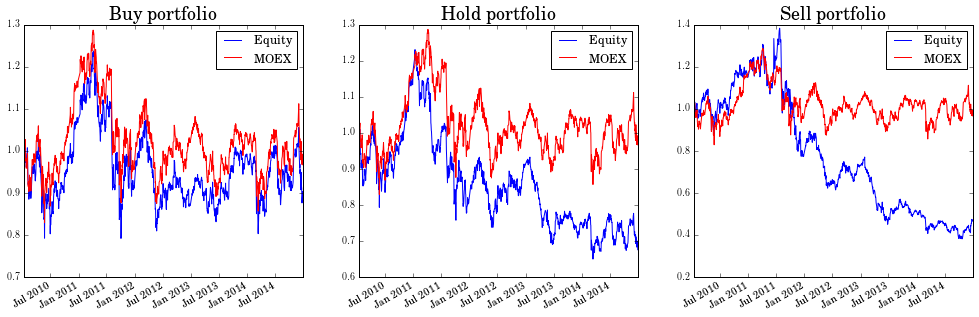

In [157]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

Buy_10_14.plot(ax=axes[0], color=['blue', 'red'], title="Buy portfolio")
Hold_10_14.plot(ax=axes[1], color=['blue', 'red'], title="Hold portfolio")
Sell_10_14.plot(ax=axes[2], color=['blue', 'red'], title="Sell portfolio")

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

axes[0].title.set_size(18)
axes[1].title.set_size(18)
axes[2].title.set_size(18)

plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/2010-2014.png',
            dpi=150, bbox_inches='tight')

In [67]:
# 2011-2015, daily
left_d_11_15 = left_dd.loc[pd.Timestamp('2011-01-01'):pd.Timestamp('2015-12-31')].reset_index()
moex_11_15 = moex.loc[pd.Timestamp('2011-01-01'):pd.Timestamp('2015-12-31')]

Buy_11_15, Hold_11_15, Sell_11_15 = get_portfolios_mm(left_d_11_15, moex_11_15)


In [68]:
P_11_15 = np.array([(annual_ret(Buy_11_15)[0]-annual_ret(Buy_11_15)[1])/250, 
           (annual_ret(Hold_11_15)[0]-annual_ret(Hold_11_15)[1])/250,
          (annual_ret(Sell_11_15)[0]-annual_ret(Sell_11_15)[1])/250])

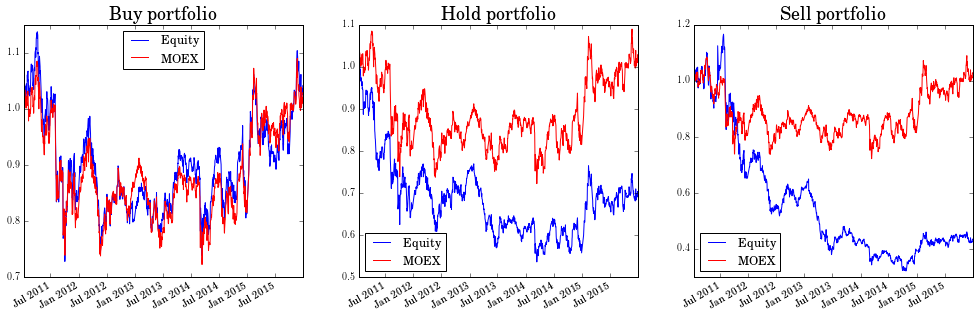

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

Buy_11_15.plot(ax=axes[0], color=['blue', 'red'], title="Buy portfolio")
Hold_11_15.plot(ax=axes[1], color=['blue', 'red'], title="Hold portfolio")
Sell_11_15.plot(ax=axes[2], color=['blue', 'red'], title="Sell portfolio")
axes[0].title.set_size(18)
axes[1].title.set_size(18)
axes[2].title.set_size(18)

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/2011-2015.png', 
            dpi=150, bbox_inches='tight')

In [69]:
# 2012-2016, daily
left_d_12_16 = left_dd.loc[pd.Timestamp('2012-01-01'):pd.Timestamp('2016-12-31')].reset_index()
moex_12_16 = moex.loc[pd.Timestamp('2012-01-01'):pd.Timestamp('2016-12-31')]

Buy_12_16, Hold_12_16, Sell_12_16 = get_portfolios_mm(left_d_12_16, moex_12_16)

In [70]:
P_12_16 = np.array([(annual_ret(Buy_12_16)[0]-annual_ret(Buy_12_16)[1])/250, 
           (annual_ret(Hold_12_16)[0]-annual_ret(Hold_12_16)[1])/250,
          (annual_ret(Sell_12_16)[0]-annual_ret(Sell_12_16)[1])/250])

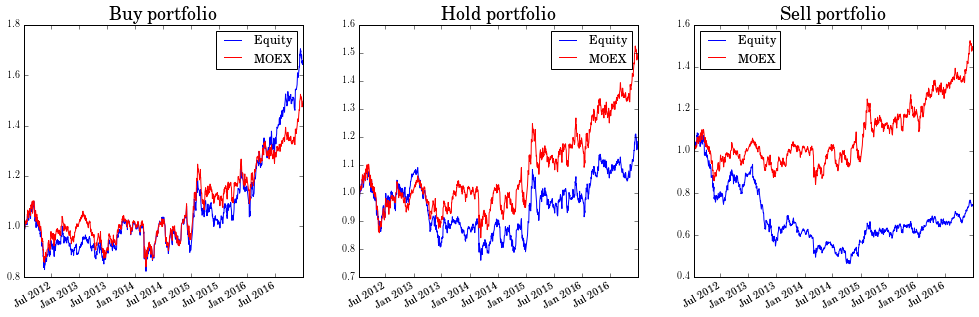

In [159]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

Buy_12_16.plot(ax=axes[0], color=['blue', 'red'], title="Buy portfolio")
Hold_12_16.plot(ax=axes[1], color=['blue', 'red'], title="Hold portfolio")
Sell_12_16.plot(ax=axes[2], color=['blue', 'red'], title="Sell portfolio")
axes[0].title.set_size(18)
axes[1].title.set_size(18)
axes[2].title.set_size(18)

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/2012-2016.png', 
            dpi=150, bbox_inches='tight')

### матрица Q

In [72]:
test_dates = Dates.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')].reset_index()

In [73]:
Q = np.zeros((len(test_dates),3))

In [74]:
for index, row in test_dates.iterrows():
    if row['Date'].year == 2015:
        Q[index] = P_10_14
    elif row['Date'].year == 2016:
        Q[index] = P_11_15
    else:
        Q[index] = P_12_16

In [75]:
Q = pd.DataFrame(Q, columns = ['Buy', 'Hold', 'Sell'], index = test_dates['Date'])

In [76]:
Q.to_csv("Q_matrix_2.csv", sep=";")

In [607]:
Q.shape

(739, 3)

In [71]:
Q.tail()

NameError: name 'Q' is not defined

## Несклонность к риску, $\delta$

In [411]:
moexfull = pd.read_csv('full_moex.csv', sep=';')
moexfull['Date'] = pd.to_datetime(moexfull['Date'], format='%d/%m/%Y')

In [412]:
moexfull = moexfull.set_index('Date')
moexfull = moexfull.loc[pd.Timestamp('2005-01-01'):pd.Timestamp('2015-01-01')]

In [413]:
moexfull.iloc[-1]

Last    1425.72
Name: 2014-12-30 00:00:00, dtype: float64

In [431]:
mret = (moexfull.iloc[-1]/moexfull.iloc[0]-1)/10
mret

Last    0.15818
dtype: float64

In [462]:
rf10y = 7.7742/100

In [458]:
moexfull_m = moexfull.resample('q').last() 

In [459]:
moexfull_m_ret = moexfull_m.apply(lambda x: np.log(x) - np.log(x.shift(1))).dropna()

In [460]:
moexfull_m_ret.var()

Last    0.029891
dtype: float64

In [463]:
delta = (mret-rf10y)/moexfull_m_ret.var()
delta

Last    2.691018
dtype: float64

In [63]:
#pd.DataFrame(Sell_price, columns=prices.columns, index=prices.index).to_csv("Sell_price.csv", sep=";")

# для проверки что все правильно считается выгрузка в эксель

# Sell_equity_mm_full = np.ones((prices.shape[0],prices.shape[1]+1))

# for i in range(1, prices.shape[0]):
#     Sell_equity_mm_full[i, :-1] = Sell_weights[i-1]*Sell_equity_mm_full[i-1, -1]*All_return[i]
#     Sell_equity_mm_full[i, -1] = np.sum(Sell_equity_mm_full[i, :-1])

# Sell_mm = pd.DataFrame(Sell_equity_mm_full, index=prices.index, columns= prices.columns.append(pd.Index(['Equity'])))
# Sell_mm['Type'] = 'MM'

# Sell_re = pd.DataFrame(All_return, index=prices.index, columns= prices.columns)
# Sell_re['Equity'] = ""
# Sell_re['Type'] = "Return"

# Sell_w = pd.DataFrame(Sell_weights, index=prices.index, columns= prices.columns)
# Sell_w['Equity'] = ""
# Sell_w['Type'] = "Weight"

# result = pd.concat([Sell_re, Sell_w, Sell_mm]).sort_index()

# result.to_csv("Sell_result.csv", sep=";")